In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split 
import torchvision.transforms as transforms
import torchvision.transforms.v2 as transforms2
import numpy as np
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
from scipy import ndimage

# Dataset

In [2]:
class PieChartDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])  # assuming filename column is at index 1
        image = Image.open(img_name).convert("RGB")
        
        # Assuming you have some transformation to apply to the image
        # if self.transform:
        #    image = self.transform(image)
            
        keypoints = self.data_frame.iloc[idx, 2]  # assuming keypoints column is at index 2
        keypoints = np.array(eval(keypoints))    # convert string representation to numpy array
        first_4_coords = [kp[:4] for kp in keypoints]
        keypoints = [[[x1, y1], [x2, y2]] for x1, y1, x2, y2 in first_4_coords]
        keypoints = np.concatenate(keypoints, axis=0)
        
        image, keypoints = self.resize_image_and_keypoints(image, keypoints)
        
        heatmap = self.generate_heatmap(image.size[0], image.size[1], keypoints)
        heatmap = torch.tensor(heatmap)
        
        if self.transform:
            image = self.transform(image)
            
        return image, heatmap

    def generate_heatmap(self, image_height, image_width, keypoints):
        """
        Generate a heatmap with keypoints represented as small Gaussians.

        Args:
        - image_height: Height of the image.
        - image_width: Width of the image.
        - keypoints: List of keypoints where each keypoint is represented as [x, y].

        Returns:
        - heatmap: A 1xHxW heatmap with Gaussians at keypoint positions.
        """
        # Initialize heatmap
        heatmap = np.zeros((1, image_width, image_height), dtype=np.float32)
        
        # Standard deviation of Gaussian
        std = 1

        for kp in keypoints:
            x, y = kp
            X, Y = np.meshgrid(np.arange(image_height), np.arange(image_width)) 
            d2 = (X - x)**2 + (Y - y)**2

            # Generate Gaussian kernel
            kernel = np.exp(-0.5 * d2 / std**2)

            # Add Gaussian kernel to heatmap
            heatmap[0, :, :] += kernel

        return heatmap
    
    def resize_image_and_keypoints(self, image, keypoints, dimensions=(256, 256)):
        # Resize image
        resized_image = image.resize(dimensions, Image.LANCZOS)

        # Calculate scaling factors
        scale_x = dimensions[1] / image.width
        scale_y = dimensions[0] / image.height

        # Resize keypoints
        resized_keypoints = []
        for kp in keypoints:
            x = int(kp[0] * scale_x)
            y = int(kp[1] * scale_y)
            resized_keypoints.append([x, y])

        return resized_image, resized_keypoints

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
torch.float32 torch.float32


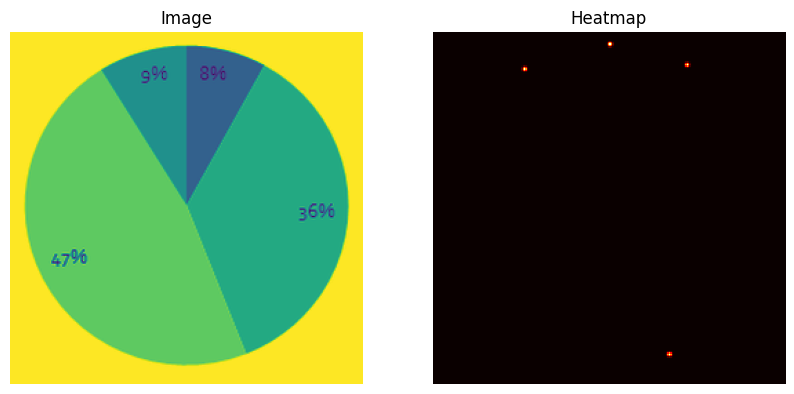

In [3]:
csv_file = '/kaggle/input/croppedimages2/updated_data.csv'
root_dir = '/kaggle/input/croppedimages2/cropped_images/cropped_images/'

# Define transformations
transform = transforms.Compose([    
    transforms.ToTensor(),  # Convert to tensor
    transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=.5, contrast=.5)], p=0.4),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms2.RandomGrayscale(0.5),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

pie_chart_dataset = PieChartDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

image, heatmap = pie_chart_dataset[3006]
print(image.shape, heatmap.shape)
print(image.dtype, heatmap.dtype)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
# Display image
axes[0].imshow(image[0])
axes[0].set_title('Image')
axes[0].axis('off')

# Display heatmap
axes[1].imshow(heatmap[0], cmap='hot', interpolation='nearest')
axes[1].set_title('Heatmap')
axes[1].axis('off')

# Draw keypoints on the image
# for kp in keypoints[0]:
#    axes[0].scatter(kp[0], kp[1], color='red', marker='o', s=10)

plt.show()


# Model

In [4]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)         
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)         
        self.relu = nn.ReLU()     
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))     
    
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)     
        
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class UNetBig(nn.Module):
    def __init__(self):
        super().__init__()
        
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)         
        
        """ Bottleneck """
        self.b = conv_block(512, 1024)    
        
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)         
        
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)         
        
        """ Bottleneck """
        b = self.b(p4)         
        
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)         
        
        """ Classifier """
        outputs = self.outputs(d4) 
        outputs = self.sigmoid(outputs)
        
        return outputs

In [5]:
# Create dataset
csv_file = '/kaggle/input/croppedimages2/updated_data.csv'
root_dir = '/kaggle/input/croppedimages2/cropped_images/cropped_images/'

# Define transformations
transform = transforms.Compose([    
    transforms.ToTensor(),  # Convert to tensor
    transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=.5, contrast=.5)], p=0.4),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms2.RandomGrayscale(0.5),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

pie_chart_dataset = PieChartDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Split dataset into train and validation sets
train_size = int(0.95 * len(pie_chart_dataset))
valid_size = len(pie_chart_dataset) - train_size
train_dataset, valid_dataset = random_split(pie_chart_dataset, [train_size, valid_size])

# Create dataloaders
BATCH_SIZE = 24
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the model
model = UNetBig()
model.to(torch.device('cuda'))

# Define loss function and optimizer
def criterion(output, target):
    loss = torch.sum((output - target)**2)
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3, 5, 7, 9], gamma=0.5)

print("Cuda available:", torch.cuda.is_available())

Cuda available: True


In [6]:
# Train
num_epochs = 10

best_val = 10000000

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
                
        images = images.to(torch.device('cuda'))
        targets = targets.to(torch.device('cuda'))
        
        # Forward pass
        outputs = model(images)
                
        # Compute loss
        loss = criterion(outputs, targets)
                
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        if i % 50 == 0:
            print("Training Step ", (i+1), "/", len(train_loader), "\t Trainloss: ", train_loss/((i+1) * BATCH_SIZE), "total: ", train_loss)

        
    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for i, (images, targets) in enumerate(valid_loader):
                        
            images = images.to(torch.device('cuda'))
            targets = targets.to(torch.device('cuda'))

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, targets)

            valid_loss += loss.item() * images.size(0)
            
            if i % 2 == 0:
                print("Validation Step ", (i+1), "/", len(valid_loader), "\t Validloss: ", valid_loss/((i+1) * BATCH_SIZE), "total: ", valid_loss)


    # Average loss
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    
    if valid_loss < best_val:
        best_val = valid_loss
        print("Saving best new best model")
        torch.save(model.state_dict(), 'best.pt')
    
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

print('Training complete.')

Training Step  1 / 396 	 Trainloss:  303633.5 total:  7287204.0
Training Step  51 / 396 	 Trainloss:  28966.14768114277 total:  35454564.76171875
Training Step  101 / 396 	 Trainloss:  15767.457861569848 total:  38220317.85644531
Training Step  151 / 396 	 Trainloss:  11243.084971446864 total:  40744939.93652344
Training Step  201 / 396 	 Trainloss:  8947.833946114155 total:  43164350.95605469
Training Step  251 / 396 	 Trainloss:  7557.844331657744 total:  45528454.25390625
Training Step  301 / 396 	 Trainloss:  6622.3003091907185 total:  47839497.43359375
Training Step  351 / 396 	 Trainloss:  5956.011060404981 total:  50173437.17285156
Validation Step  1 / 21 	 Validloss:  1594.160888671875 total:  38259.861328125
Validation Step  3 / 21 	 Validloss:  1733.28125 total:  124796.25
Validation Step  5 / 21 	 Validloss:  1794.134326171875 total:  215296.119140625
Validation Step  7 / 21 	 Validloss:  1839.1192801339287 total:  308972.0390625
Validation Step  9 / 21 	 Validloss:  1886.94

In [7]:
model.eval()
image, target = valid_dataset[0]

single_image_batch = torch.unsqueeze(torch.tensor(image), 0).to(torch.device('cuda'))
prediction = model(single_image_batch)

print(prediction.shape)

prediction = prediction.to(torch.device('cpu'))
print(criterion(prediction, target))
prediction = prediction.detach().numpy()

print(torch.sum((target - prediction)**2))
print(target - prediction)

torch.Size([1, 1, 256, 256])
tensor(23.2307, grad_fn=<SumBackward0>)
tensor(23.2307)
tensor([[[[-0.0017, -0.0053, -0.0027,  ..., -0.0012, -0.0013, -0.0005],
          [-0.0051, -0.0221, -0.0087,  ..., -0.0069, -0.0065, -0.0013],
          [-0.0026, -0.0077, -0.0038,  ..., -0.0046, -0.0045, -0.0010],
          ...,
          [-0.0019, -0.0064, -0.0029,  ..., -0.0045, -0.0060, -0.0014],
          [-0.0029, -0.0121, -0.0044,  ..., -0.0256, -0.0365, -0.0049],
          [-0.0008, -0.0022, -0.0014,  ..., -0.0056, -0.0066, -0.0018]]]])


/tmp/ipykernel_24/1514535033.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single_image_batch = torch.unsqueeze(torch.tensor(image), 0).to(torch.device('cuda'))


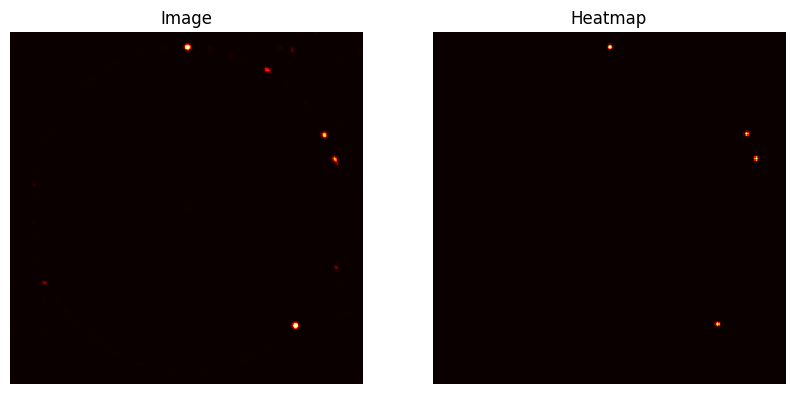

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
# Display image
axes[0].imshow(prediction[0][0], cmap='hot')
axes[0].set_title('Image')
axes[0].axis('off')

# Display heatmap
axes[1].imshow(target[0], cmap='hot', interpolation='nearest')
axes[1].set_title('Heatmap')
axes[1].axis('off')

# Draw keypoints on the image
# for kp in keypoints[0]:
#    axes[0].scatter(kp[0], kp[1], color='red', marker='o', s=10)

plt.show()

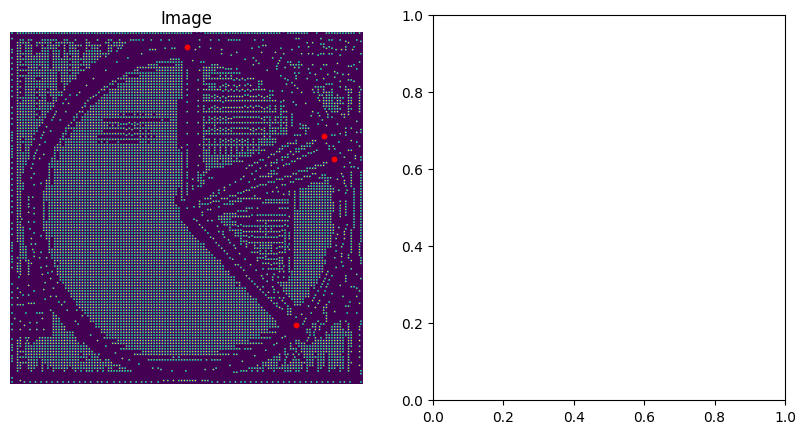

In [9]:
maximum_candidates = ndimage.maximum_filter(prediction[0][0], size=3) == prediction[0][0] # True if a point is the biggest in his region
corner_candidates = prediction[0][0] > 0.5

corners = np.where((maximum_candidates & corner_candidates))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
# Display image
axes[0].imshow(maximum_candidates)
axes[0].set_title('Image')
axes[0].axis('off')

for x, y in zip(corners[0], corners[1]):
    axes[0].scatter(y, x, color='red', marker='o', s=10)

plt.show()

# Test

In [10]:
#model = UNetBig()
#file_path = '/kaggle/input/unetmodel/best.pt'
#model.load_state_dict(torch.load(file_path))
#model.to(torch.device('cuda'))

In [11]:
class PieChartTestDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])  # assuming filename column is at index 1
        image = Image.open(img_name).convert("RGB")
        
        self.data_frame.iloc[idx, 2] = image.size[1] # width
        self.data_frame.iloc[idx, 3] = image.size[0] # height
        
        image, keypoints = self.resize_image_and_keypoints(image, [])
        
        if self.transform:
            image = self.transform(image)
            
        return image
    
    
    def resize_image_and_keypoints(self, image, keypoints, dimensions=(256, 256)):
        # Resize image
        resized_image = image.resize(dimensions, Image.LANCZOS)

        # Calculate scaling factors
        scale_x = dimensions[1] / image.width
        scale_y = dimensions[0] / image.height

        # Resize keypoints
        resized_keypoints = []
        for kp in keypoints:
            x = int(kp[0] * scale_x)
            y = int(kp[1] * scale_y)
            resized_keypoints.append([x, y])

        return resized_image, resized_keypoints

In [12]:
valid_test_csv_file = '/kaggle/input/think-cell-datathon/val_and_test.csv'
valid_test_root_dir = '/kaggle/input/croppedimages2/cropped_images (2)/cropped_images'

valid_test_data = pd.read_csv(valid_test_csv_file)
valid_test_data["image_height"] = 0
valid_test_data["image_width"] = 0

torch.Size([3, 256, 256])
torch.float32


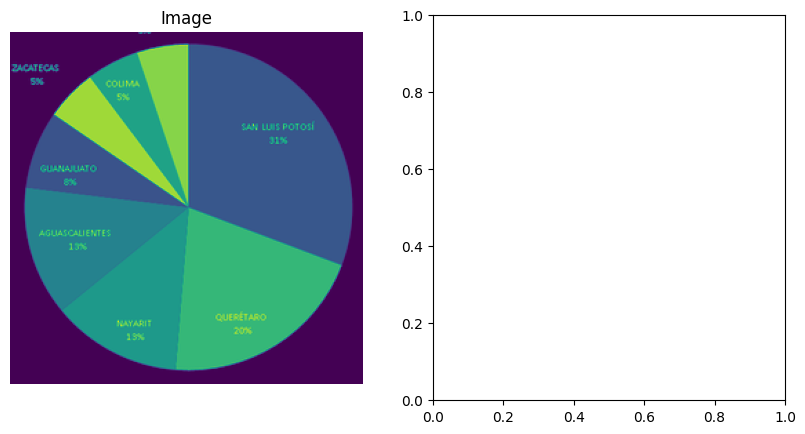

In [13]:
# Define transformations
valid_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

valid_test_dataset = PieChartTestDataset(data_frame=valid_test_data, root_dir=valid_test_root_dir, transform=valid_test_transform)

image = valid_test_dataset[1]
print(image.shape)
print(image.dtype)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
# Display image
axes[0].imshow(image[0])
axes[0].set_title('Image')
axes[0].axis('off')


# Draw keypoints on the image
# for kp in keypoints[0]:
#    axes[0].scatter(kp[0], kp[1], color='red', marker='o', s=10)

plt.show()


In [14]:
def un_resize_keypoints(image_width, image_height, keypoints):
    
    # Calculate scaling factors
    scale_x = 256 / image_width
    scale_y = 256 / image_height

    # Resize keypoints
    resized_keypoints = []
    for kp in keypoints:
        x = int(kp[0] / scale_x)
        y = int(kp[1] / scale_y)
        resized_keypoints.append([x, y])

    return resized_keypoints

In [15]:
valid_test_loader = DataLoader(valid_test_dataset, batch_size=1, shuffle=False)


# Validation
model.eval()
with torch.no_grad():
    for i, images in enumerate(valid_test_loader):
        
        if i >= 10000: # No test data yet
            break
        
        if i % 100 == 0:
            print(i, '/', len(valid_test_loader))

        images = images.to(torch.device('cuda'))

        # Forward pass
        outputs = model(images)
        outputs = outputs.to(torch.device('cpu')).detach().numpy()

        maximum_candidates = ndimage.maximum_filter(outputs[0][0], size=3) == outputs[0][0] # True if a point is the biggest in his region
        corner_candidates = outputs[0][0] > 0.5

        corners = np.where((maximum_candidates & corner_candidates))
        corners = [(x,y) for x,y in zip(corners[0], corners[1])]
        
        original_image_width = valid_test_data.iloc[i, 2]
        original_image_height = valid_test_data.iloc[i, 3]
        final_predicitons = un_resize_keypoints(original_image_width, original_image_height, corners)
        valid_test_data.at[i, 'prediction'] = str(final_predicitons)
        
        #if i == 0:
        #    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # Display image
        #    axes[0].imshow(outputs[0][0])
        #    axes[0].set_title('Image')
        #    axes[0].axis('off')

        #    for x, y in zip(corners[0], corners[1]):
        #        axes[0].scatter(x, y, color='red', marker='o', s=10)

         #   plt.show()



0 / 20000
100 / 20000
200 / 20000
300 / 20000
400 / 20000
500 / 20000
600 / 20000
700 / 20000
800 / 20000
900 / 20000
1000 / 20000
1100 / 20000
1200 / 20000
1300 / 20000
1400 / 20000
1500 / 20000
1600 / 20000
1700 / 20000
1800 / 20000
1900 / 20000
2000 / 20000
2100 / 20000
2200 / 20000
2300 / 20000
2400 / 20000
2500 / 20000
2600 / 20000
2700 / 20000
2800 / 20000
2900 / 20000
3000 / 20000
3100 / 20000
3200 / 20000
3300 / 20000
3400 / 20000
3500 / 20000
3600 / 20000
3700 / 20000
3800 / 20000
3900 / 20000
4000 / 20000
4100 / 20000
4200 / 20000
4300 / 20000
4400 / 20000
4500 / 20000
4600 / 20000
4700 / 20000
4800 / 20000
4900 / 20000
5000 / 20000
5100 / 20000
5200 / 20000
5300 / 20000
5400 / 20000
5500 / 20000
5600 / 20000
5700 / 20000
5800 / 20000
5900 / 20000
6000 / 20000
6100 / 20000
6200 / 20000
6300 / 20000
6400 / 20000
6500 / 20000
6600 / 20000
6700 / 20000
6800 / 20000
6900 / 20000
7000 / 20000
7100 / 20000
7200 / 20000
7300 / 20000
7400 / 20000
7500 / 20000
7600 / 20000
7700 / 2000

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/croppedimages2/cropped_images (2)/cropped_images/chart_20000.png'

In [ ]:
valid_test_data.iloc[9000]

In [ ]:
submission = valid_test_data[['id', 'prediction']]
submission.to_csv('edge_points.csv')

In [ ]:
test = '990'

img_name = f'/kaggle/input/croppedimages2/cropped_images (2)/cropped_images/chart_10{test}.png'
image = Image.open(img_name).convert("RGB")


keypoints = valid_test_data.iloc[int(test), 4]  # assuming keypoints column is at index 2
keypoints = np.array(eval(keypoints))    # convert string representation to numpy array

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display image
axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')

for x, y in keypoints:
    axes[0].scatter(y, x, color='red', marker='o', s=10)

plt.show()